# The art of using pipelines

Pipelines are a natural way to think about a machine learning system. Indeed with some practice a data scientist can visualise data "flowing" through a series of steps. The input is typically some raw data which has to be processed in some manner. The goal is to represent the data in such a way that is can be ingested by a machine learning algorithm. Along the way some steps will extract features, while others will normalize the data and remove undesirable elements. Pipelines are simple, and yet they are a powerful way of designing sophisticated machine learning systems.

Both [scikit-learn](https://stackoverflow.com/questions/33091376/python-what-is-exactly-sklearn-pipeline-pipeline) and [pandas](https://tomaugspurger.github.io/method-chaining) make it possible to use pipelines. However it's quite rare to see pipelines being used in practice (at least on Kaggle). Sometimes you get to see people using scikit-learn's `pipeline` module, however the `pipe` method from `pandas` is sadly underappreciated. A big reason why pipelines are not given much love is that it's easier to think of batch learning in terms of a script or a notebook. Indeed many people doing data science seem to prefer a procedural style to a declarative style. Moreover in practice pipelines can be a bit rigid if one wishes to do non-orthodox operations.

Although pipelines may be a bit of an odd fit for batch learning, they make complete sense when they are used for online learning. Indeed the UNIX philosophy has advocated the use of pipelines for data processing for many decades. If you can visualise data as a stream of observations then using pipelines should make a lot of sense to you. We'll attempt to convince you by writing a machine learning algorithm in a procedural way and then converting it to a declarative pipeline in small steps. Hopefully by the end you'll be convinced, or not!

In this notebook we'll manipulate data from the [Kaggle Recruit Restaurants Visitor Forecasting competition](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting). The data is directly available through `creme`'s `datasets` module.

In [1]:
from pprint import pprint
from creme import datasets

for x, y in datasets.fetch_restaurants():
    pprint(x)
    pprint(y)
    break

{'area_name': 'Tōkyō-to Nerima-ku Toyotamakita',
 'date': datetime.datetime(2016, 1, 1, 0, 0),
 'genre_name': 'Izakaya',
 'is_holiday': True,
 'latitude': 35.7356234,
 'longitude': 139.6516577,
 'store_id': 'air_04341b588bde96cd'}
10


We'll start by building and running a model using a procedural coding style. The performance of the model doesn't matter, we're simply interested in the design of the model.

In [2]:
from creme import feature_extraction
from creme import linear_model
from creme import metrics
from creme import preprocessing
from creme import stats


means = (
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(7)),
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(14)),
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(21))
)

scaler = preprocessing.StandardScaler()
lin_reg = linear_model.LinearRegression()
metric = metrics.MAE()

for x, y in datasets.fetch_restaurants():
    
    # Derive date features
    x['weekday'] = x['date'].weekday()
    x['is_weekend'] = x['date'].weekday() in (5, 6)
    
    # Process the rolling means of the target  
    for mean in means:
        x = {**x, **mean.transform_one(x)}
        mean.fit_one(x, y)
    
    # Remove the key/value pairs that aren't features
    for key in ['store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude']:
        x.pop(key)
    
    # Rescale the data
    x = scaler.fit_one(x, y).transform_one(x)
    
    # Fit the linear regression
    y_pred = lin_reg.predict_one(x)
    lin_reg.fit_one(x, y)
    
    # Update the metric using the out-of-fold prediction
    metric.update(y, y_pred)
    
print(metric)

MAE: 8.062704


We're not using many features. We can print the last `x` to get an idea of the features (don't forget they've been scaled!)

In [3]:
pprint(x)

{'is_holiday': -0.23103527856814762,
 'is_weekend': 1.624924784947841,
 'target_rolling_rollingmean_14_by_store_id': -1.412588580015128,
 'target_rolling_rollingmean_21_by_store_id': -1.3980951347116455,
 'target_rolling_rollingmean_7_by_store_id': -1.3502287720952852,
 'weekday': 1.029281216558448}


The above chunk of code is quite explicit but it's a bit verbose. The whole point of libraries such as `creme` is to make life easier for users. Moreover there's too much space for users to mess up the order in which things are done, which increases the chance of there being target leakage. We'll now rewrite our model in a declarative fashion using a pipeline *à la sklearn*.  

In [4]:
from creme import compose


def get_date_features(x):
    weekday =  x['date'].weekday()
    return {'weekday': weekday, 'is_weekend': weekday in (5, 6)}


model = compose.Pipeline([
    ('features', compose.TransformerUnion([
        ('date_features', compose.FuncTransformer(get_date_features)),
        ('last_7_mean', feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(7))),
        ('last_14_mean', feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(14))),
        ('last_21_mean', feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(21)))
    ])),
    ('drop_non_features', compose.Blacklister('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude')),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
])

metric = metrics.MAE()

for x, y in datasets.fetch_restaurants():
    
    # Make a prediction without using the target
    y_pred = model.predict_one(x)
    
    # Update the model using the target
    model.fit_one(x, y)
    
    # Update the metric using the out-of-fold prediction
    metric.update(y, y_pred)
    
print(metric)

MAE: 8.058084


We use a `Pipeline` to arrange each step in a sequential order. A `TransformerUnion` is used to merge multiple feature extractors into a single transformer. The `for` loop is now much shorter and is thus easier to grok: we get the out-of-fold prediction, we fit the model, and finally we update the metric. This way of evaluating a model is typical of online learning, and so we put it wrapped it inside a function called `online_score` part of the `model_selection` module. We can use it to replace the `for` loop.

In [5]:
from creme import model_selection

model = compose.Pipeline([
    ('features', compose.TransformerUnion([
        ('date_features', compose.FuncTransformer(get_date_features)),
        ('last_7_mean', feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(7))),
        ('last_14_mean', feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(14))),
        ('last_21_mean', feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(21)))
    ])),
    ('drop_non_features', compose.Blacklister('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude')),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
])

model_selection.online_score(X_y=datasets.fetch_restaurants(), model=model, metric=metrics.MAE())

MAE: 8.058084

Notice that you couldn't have used the `online_score` method if you wrote the model in a procedural manner.

Our code is getting shorter, but it's still a bit difficult on the eyes. Indeed there is a lot of boilerplate code associated with pipelines that can get tedious to write. However `creme` has some special tricks up it's sleeve to save you from a lot of pain.

The first trick is that the name of each step in the pipeline can be omitted. If no name is given for a step then `creme` automatically infers one.

In [6]:
model = compose.Pipeline([
    compose.TransformerUnion([
        compose.FuncTransformer(get_date_features),
        feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(7)),
        feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(14)),
        feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(21))
    ]),
    compose.Blacklister('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
])

model_selection.online_score(datasets.fetch_restaurants(), model, metrics.MAE())

MAE: 8.058084

Under the hood a `Pipeline` inherits from `collections.OrderedDict`. Indeed this makes sense because if you think about it a `Pipeline` is simply a sequence of steps where each step has a name. The reason we mention this is because it means you can manipulate a `Pipeline` the same way you would manipulate an ordinary `dict`. For instance we can print the name of each step by using the `keys` method.

In [7]:
for name in model.keys():
    print(name)

get_date_features + target_rolling_rollingmean_7_by_store_id + target_rolling_rollingmean_14_by_store_id + target_rolling_rollingmean_21_by_store_id
~['area_name', 'date', 'genre_name', 'latitude', 'longitude', 'store_id']
StandardScaler
LinearRegression


The first step is a `FeatureUnion` and it's string representation contains the string representation of each of it's elements. Not having to write names saves up some time and space and is certainly less tedious.

The next trick is that we can use mathematical operators to compose our pipeline. For example we can use the `+` operator to merge `Transformer`s into a `TransformerUnion`. 

In [8]:
model = compose.Pipeline([
    compose.FuncTransformer(get_date_features) + \
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(7)) + \
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(14)) + \
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(21)),

    compose.Blacklister('store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude'),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
])

model_selection.online_score(datasets.fetch_restaurants(), model, metrics.MAE())

MAE: 8.058084

Likewhise we can use the `|` operator to assemble steps into a `Pipeline`. 

In [9]:
model = (
    compose.FuncTransformer(get_date_features) +
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(7)) +
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(14)) +
    feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(21))
)

to_discard = ['store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude']

model = model | compose.Blacklister(*to_discard) | preprocessing.StandardScaler()

model |= linear_model.LinearRegression()

model_selection.online_score(datasets.fetch_restaurants(), model, metrics.MAE())

MAE: 8.058084

Hopefully you'll agree that this is a powerful way to express machine learning pipelines. For some people this should be quite remeniscent of the UNIX pipe operator. One final trick we want to mention is that functions are automatically wrapped with a `FuncTransformer`, which can be quite handy.

In [10]:
model = get_date_features

for n in [7, 14, 21]:
    model += feature_extraction.TargetAgg(by='store_id', how=stats.RollingMean(n))

model |= compose.Blacklister(*to_discard)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

model_selection.online_score(datasets.fetch_restaurants(), model, metrics.MAE())

MAE: 8.058084

Naturally some may prefer the procedural style we first used because they find it easier to work with. It all depends on your style and you should use what you feel comfortable with. However we encourage you to use operators because we believe that this will increase the readability of your code, which is very important. To each their own!

Before finishing we can take a look at what our pipeline looks graphically.

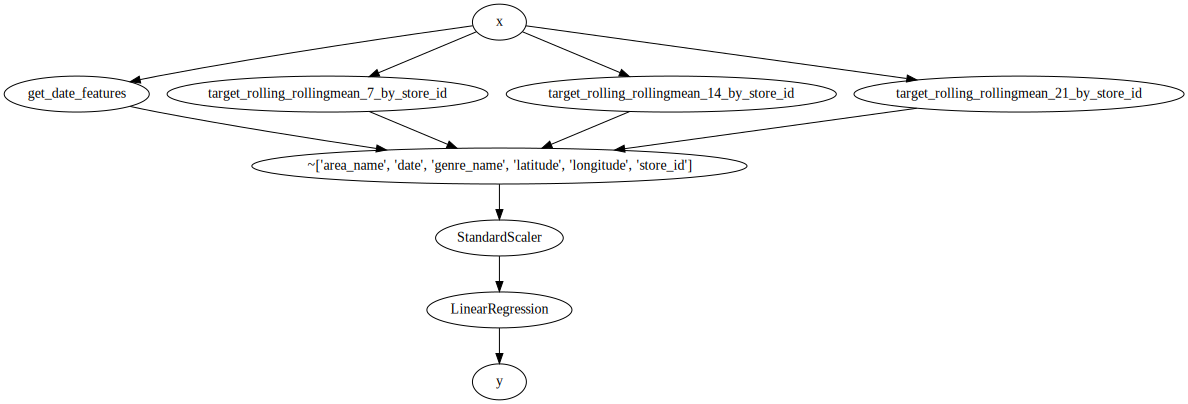

In [11]:
model.draw()